In [69]:
from iads.data_traitement import traitement
from iads.nlp import preprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, SlopeOne
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans

from tqdm import tqdm
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# I. Chargement des données :

In [6]:
df_jeux = pd.read_csv("../data/details_desc.csv")
df_jeux.head(2)

,categories,titre,description,full_title,Note Finkel,Note rectifiée,Nombre d'avis rectifiés,Note,Nombre d'avis,_id,...,editors,distributors,nb_players,age_required,duration,enfant,ado,adulte,solo,multi
0,NaN,Marvel United,marvel united unis contre super vilain red sku...,Marvel United (2020),8.74,8.40,10.0,7.58,19.0,marvel-united,...,CMON Limited,NaN,1-4,14-99,45.0,0,1,1,1,1
1,NaN,Mariposas,annee printemps million papillon monarque quit...,Mariposas (2020),7.68,7.29,17.0,7.39,33.0,mariposas,...,Gigamic,NaN,2-5,14-99,60.0,0,1,1,0,1


In [3]:
df_avis = pd.read_csv("../data/avis_clean.csv")
df_avis.head(2)

,comment,treated,date_published,title_review,author,note,title,title_id_jeu
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",True,2021,Voyages sur les ailes des papillons,Monsieur Guillaume,8.0,Mariposas,mariposas
1,Comment continuer après un mega hit ? Simpleme...,True,2020,le festival de Michoacan,morlockbob,7.0,Mariposas,mariposas


In [6]:
# users = list(df_avis['author'].unique())
# games = list(df_jeux['_id'].unique())

# ratings_matrix = np.zeros((len(users), len(games)))

# for _, row in tqdm(df_avis.iterrows(), total=len(df_avis)):
#     i = users.index(row['author'])
#     j = games.index(row['title_id_jeu'])
    
#     ratings_matrix[i, j] = row['note']

In [8]:
users = df_avis['author'].unique()
games = df_jeux['_id'].unique()

ratings_matrix = np.zeros((len(users), len(games)))

for i, user in tqdm(enumerate(users), total=len(users), desc='Processing users'):
    user_games = df_avis[df_avis['author'] == user].groupby('title_id_jeu')
    
    for game, reviews in user_games:
        j = np.where(games == game)[0][0]
        max_date = reviews['date_published'].max()
        ratings_matrix[i, j] = reviews[reviews['date_published'] == max_date].iloc[0]["note"]

Processing users: 100%|██████████| 13623/13623 [03:13<00:00, 70.41it/s] 


In [13]:
print(ratings_matrix)
nombre_zeros=np.count_nonzero(ratings_matrix == 0)/(np.shape(ratings_matrix)[0]*np.shape(ratings_matrix)[1])
print(nombre_zeros*100, "% des éléments sont nuls")

[[0. 8. 0. ... 0. 0. 0.]
 [0. 7. 7. ... 0. 0. 0.]
 [0. 7. 8. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
99.92344499822434 % des éléments sont nuls


La matrice est donc peu exploitable

## Statistiques

In [5]:
nb_users = len(df_avis["author"].unique())
nb_jeux = len(df_avis["title_id_jeu"].unique())

print(f"Il y a {nb_users} utilisateurs et {nb_jeux} jeux")

Il y a 13623 utilisateurs et 10936 jeux


In [14]:
df_avis["note"].describe()

count    176243.000000
mean          7.478046
std           2.171968
min           0.000000
25%           6.000000
50%           8.000000
75%           9.300000
max          10.000000
Name: note, dtype: float64

<AxesSubplot:xlabel='note', ylabel='Density'>

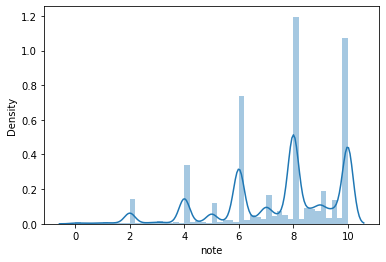

In [16]:
sns.distplot(df_avis["note"])   

Distribution par utilisateur

<AxesSubplot:xlabel='note', ylabel='Density'>

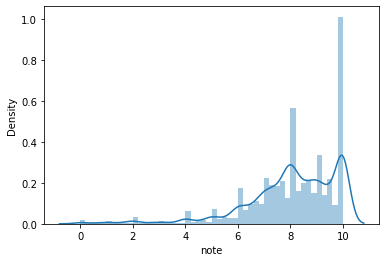

In [17]:
user_means = df_avis.groupby("author")["note"].mean()
sns.distplot(user_means)

Distribution par jeu

<AxesSubplot:xlabel='note', ylabel='Density'>

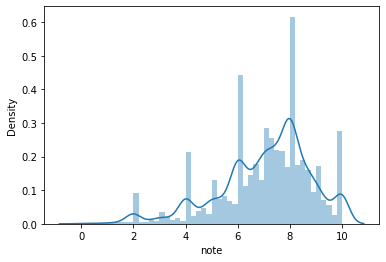

In [21]:
item_means = df_avis.groupby("title_id_jeu")["note"].mean()
sns.distplot(item_means)

Créons un nouveau dataframe qui prend en compte uniquement la dernière note par utilisateur et par jeu (car nous avons pu observer qu'un utilisateur avait la possibilité de noter plusieurs fois un même jeu)

In [38]:
doublons = df_avis[df_avis.duplicated(subset=['author', 'title_id_jeu'], keep=False)]
print(doublons)

Empty DataFrame
Columns: [comment, treated, date_published, title_review, author, note, title, title_id_jeu]
Index: []


Finalement peut-ête qu'il n'y a pas de doublons... à revérifier

## Collaborative filtering

In [47]:
train_indexes,test_indexes = [],[]

for index in range(len(df_avis)):
    if index%5 == 0:
        test_indexes.append(index)
    else:
        train_indexes.append(index)

#train_ratings = df_avis.iloc[train_indexes].copy()
#test_ratings = df_avis.iloc[test_indexes].copy()

train_ratings = df_avis.loc[train_indexes, ['author', 'title_id_jeu','note']].copy()
test_ratings = df_avis.loc[test_indexes, ['author', 'title_id_jeu','note']].copy()

In [61]:
data = Dataset.load_from_df(train_ratings[['author', 'title_id_jeu', 'note']], Reader(rating_scale=(0, 10)))

### Baseline algorithm

In [70]:
def algo_pred(user_item):
    user = user_item["author"]
    game = user_item["title_id_jeu"]
    prediction = algo.predict(user,game)
    
    return prediction.est

In [49]:
algo = BaselineOnly()
algo.fit(data.build_full_trainset())

Estimating biases using als...


In [51]:
test_ratings["baseline_pred"] = test_ratings[["author","title_id_jeu"]].apply(algo_pred,axis=1)
test_ratings 

,author,title_id_jeu,note,baseline_pred
0,Monsieur Guillaume,mariposas,8.0,7.713331
5,BSI40,mariposas,7.0,7.214164
10,Max Riock,mariposas,9.0,8.191587
15,Lilly,mariposas,8.0,7.361406
20,AtomChris,mariposas,8.0,7.481426
...,...,...,...,...
176220,lionc,mag-blast-1,4.0,6.915853
176225,eric faramond,la-molle,8.8,7.412503
176230,Zombie Killer,zombie-town,8.0,8.127756
176235,Pifec,liar-s-dice,8.0,7.253719


### SVD algorithm

In [52]:
algo = SVD()
algo.fit(data.build_full_trainset())

In [55]:
test_ratings["svd_pred"] = test_ratings[["author","title_id_jeu"]].apply(algo_pred,axis=1) 
test_ratings 

,author,title_id_jeu,note,baseline_pred,svd_pred
0,Monsieur Guillaume,mariposas,8.0,7.713331,8.023848
5,BSI40,mariposas,7.0,7.214164,6.864079
10,Max Riock,mariposas,9.0,8.191587,8.510852
15,Lilly,mariposas,8.0,7.361406,7.086200
20,AtomChris,mariposas,8.0,7.481426,7.453890
...,...,...,...,...,...
176220,lionc,mag-blast-1,4.0,6.915853,6.813992
176225,eric faramond,la-molle,8.8,7.412503,7.447934
176230,Zombie Killer,zombie-town,8.0,8.127756,8.389559
176235,Pifec,liar-s-dice,8.0,7.253719,7.182032


Par défaut dans SVD n_factors (Z) est à 100 et n_epoch est à 20
On va chercher une valeur optimale pour les deux en utilisant GridSearchCV

In [71]:
def gs_pred(model, param_grid):
    gs = GridSearchCV(model, param_grid, measures=['mse'], cv=5) 

    # Créer une barre de progression
    gs_progress_bar = tqdm(total=len(gs.param_combinations))

    # Boucler sur les paramètres de la grille
    for _, param in enumerate(gs.param_combinations):
        gs.param_combinations = [param]
        # Lancer l'entraînement pour le paramètre en cours
        gs.fit(data)
        
        # Mettre à jour la barre de progression
        gs_progress_bar.update(1)

    # Fermer la barre de progression
    gs_progress_bar.close()

    print('Meilleur score au sens des moindres carrés :',gs.best_score['mse'])
    print('Meilleurs paramètres :',gs.best_params['mse'])

    #On fait tourner l'algo sur les meilleurs paramètres trouvés pour les ajouter au df
    algo = gs.best_estimator['mse']
    algo.fit(data.build_full_trainset())

    return algo

#'n_epochs': list(range(2,21,2)),
#'n_factors':list(range(25,251,25))
#Meilleur score au sens des moindres carrés : 3.736733614074802
#Meilleurs paramètres : {'n_epochs': 20, 'n_factors': 250}

In [72]:
param_grid = {'n_epochs': list(range(20,201,20)),
            'n_factors':list(range(20,201,20))}

algo = gs_pred(SVD, param_grid)

test_ratings["svd_pred_gs"] = test_ratings[["author","title_id_jeu"]].apply(algo_pred,axis=1) 
test_ratings 


  0%|          | 0/81 [00:00<?, ?it/s]

Meilleur score au sens des moindres carrés : 3.74876032407951
Meilleurs paramètres : {'n_epochs': 180, 'n_factors': 180}


,author,title_id_jeu,note,baseline_pred,svd_pred,svd_pred_gs
0,Monsieur Guillaume,mariposas,8.0,7.713331,8.023848,7.904406
5,BSI40,mariposas,7.0,7.214164,6.864079,7.507335
10,Max Riock,mariposas,9.0,8.191587,8.510852,8.447652
15,Lilly,mariposas,8.0,7.361406,7.086200,7.730151
20,AtomChris,mariposas,8.0,7.481426,7.453890,7.436795
...,...,...,...,...,...,...
176220,lionc,mag-blast-1,4.0,6.915853,6.813992,6.796394
176225,eric faramond,la-molle,8.8,7.412503,7.447934,7.477087
176230,Zombie Killer,zombie-town,8.0,8.127756,8.389559,8.266901
176235,Pifec,liar-s-dice,8.0,7.253719,7.182032,7.418546


On pourrait encore augmenter n_factors et n_epoch mais au risque de faire du sur-apprentissage...

### KNN Basic

In [73]:
param_grid = {'k': list(range(10,51,2))}

algo = gs_pred(KNNBasic, param_grid)

test_ratings["knnBasic_pred_gs"] = test_ratings[["author","title_id_jeu"]].apply(algo_pred,axis=1) 
test_ratings 

  0%|          | 0/21 [00:00<?, ?it/s]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,author,title_id_jeu,note,baseline_pred,svd_pred,svd_pred_gs,knnBasic_pred_gs
0,Monsieur Guillaume,mariposas,8.0,7.713331,8.023848,7.904406,7.441442
5,BSI40,mariposas,7.0,7.214164,6.864079,7.507335,7.116340
10,Max Riock,mariposas,9.0,8.191587,8.510852,8.447652,7.682630
15,Lilly,mariposas,8.0,7.361406,7.086200,7.730151,6.905448
20,AtomChris,mariposas,8.0,7.481426,7.453890,7.436795,7.477008
...,...,...,...,...,...,...,...
176220,lionc,mag-blast-1,4.0,6.915853,6.813992,6.796394,7.477008
176225,eric faramond,la-molle,8.8,7.412503,7.447934,7.477087,7.477008
176230,Zombie Killer,zombie-town,8.0,8.127756,8.389559,8.266901,8.386777
176235,Pifec,liar-s-dice,8.0,7.253719,7.182032,7.418546,7.477008


### KNN With Means

### SlopeOne

In [74]:
algo = SlopeOne()
algo.fit(data.build_full_trainset())

test_ratings["slopeOne_pred"] = test_ratings[["author","title_id_jeu"]].apply(algo_pred,axis=1) 
test_ratings 

,author,title_id_jeu,note,baseline_pred,svd_pred,svd_pred_gs,knnBasic_pred_gs,slopeOne_pred
0,Monsieur Guillaume,mariposas,8.0,7.713331,8.023848,7.904406,7.441442,7.482695
5,BSI40,mariposas,7.0,7.214164,6.864079,7.507335,7.116340,7.711707
10,Max Riock,mariposas,9.0,8.191587,8.510852,8.447652,7.682630,8.759819
15,Lilly,mariposas,8.0,7.361406,7.086200,7.730151,6.905448,8.408333
20,AtomChris,mariposas,8.0,7.481426,7.453890,7.436795,7.477008,7.477008
...,...,...,...,...,...,...,...,...
176220,lionc,mag-blast-1,4.0,6.915853,6.813992,6.796394,7.477008,7.477008
176225,eric faramond,la-molle,8.8,7.412503,7.447934,7.477087,7.477008,7.477008
176230,Zombie Killer,zombie-town,8.0,8.127756,8.389559,8.266901,8.386777,8.972995
176235,Pifec,liar-s-dice,8.0,7.253719,7.182032,7.418546,7.477008,7.477008


### SVD ++

In [75]:
param_grid = {'n_epochs': list(range(20,201,20)),
            'n_factors':list(range(20,201,20))}

algo = gs_pred(SVD, param_grid)

test_ratings["svdpp_pred_gs"] = test_ratings[["author","title_id_jeu"]].apply(algo_pred,axis=1) 
test_ratings 

  0%|          | 0/100 [00:00<?, ?it/s]

Meilleur score au sens des moindres carrés : 3.7266176225535688
Meilleurs paramètres : {'n_epochs': 200, 'n_factors': 200}


,author,title_id_jeu,note,baseline_pred,svd_pred,svd_pred_gs,knnBasic_pred_gs,slopeOne_pred,svdpp_pred_gs
0,Monsieur Guillaume,mariposas,8.0,7.713331,8.023848,7.904406,7.441442,7.482695,7.946669
5,BSI40,mariposas,7.0,7.214164,6.864079,7.507335,7.116340,7.711707,7.815380
10,Max Riock,mariposas,9.0,8.191587,8.510852,8.447652,7.682630,8.759819,8.111915
15,Lilly,mariposas,8.0,7.361406,7.086200,7.730151,6.905448,8.408333,7.432193
20,AtomChris,mariposas,8.0,7.481426,7.453890,7.436795,7.477008,7.477008,7.424609
...,...,...,...,...,...,...,...,...,...
176220,lionc,mag-blast-1,4.0,6.915853,6.813992,6.796394,7.477008,7.477008,6.874941
176225,eric faramond,la-molle,8.8,7.412503,7.447934,7.477087,7.477008,7.477008,7.469335
176230,Zombie Killer,zombie-town,8.0,8.127756,8.389559,8.266901,8.386777,8.972995,8.169743
176235,Pifec,liar-s-dice,8.0,7.253719,7.182032,7.418546,7.477008,7.477008,7.397375


### Meilleur algo au sens des MSE

In [76]:
def mse(predictions,truth):
    return ((predictions - truth)**2).mean()

In [89]:
results = pd.DataFrame()

results["metrics"] = ["mse"]
results["baseline_pred"] = mse(test_ratings["baseline_pred"],test_ratings["note"])
results["baseline_pred"] = mse(test_ratings["baseline_pred"],test_ratings["note"])
results["svd_pred"] = mse(test_ratings["svd_pred"],test_ratings["note"])
results["svd_pred_gs"] = mse(test_ratings["svd_pred_gs"],test_ratings["note"])
results["knnBasic_pred_gs"] = mse(test_ratings["knnBasic_pred_gs"],test_ratings["note"])
results["slopeOne_pred"] = mse(test_ratings["slopeOne_pred"],test_ratings["note"])
results["svdpp_pred_gs"] = mse(test_ratings["svdpp_pred_gs"],test_ratings["note"])

results = results.set_index("metrics")

results


,baseline_pred,svd_pred,svd_pred_gs,knnBasic_pred_gs,slopeOne_pred,svdpp_pred_gs
metrics,,,,,,
mse,3.46444,3.659692,3.680102,4.028624,3.931209,3.647404


In [91]:
print('Meilleur modèle :')
results.idxmin(1)


Meilleur modèle :


metrics
mse    baseline_pred
dtype: object